In [1]:
!pip3 install opencv_python
!pip3 install numpy
!pip3 install matplotlib

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


In [3]:
# There are some problems in notebooks with cv2 imshow, use matplotlib instead.
# conversion needed
def plt_show(img):
	image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

	plt.imshow(image_rgb)
	plt.axis('off')
	plt.show()
 
def plt_show2(img1, img2):
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1_rgb)
    axes[0].axis('off')

    axes[1].imshow(img2_rgb)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

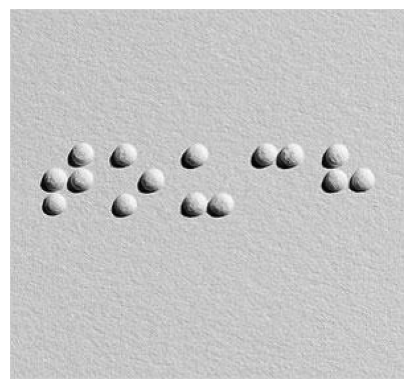

In [ ]:
# Cargar imagen
# image = cv2.imread("../images/tests/test_1.png", cv2.IMREAD_GRAYSCALE)
image = cv2.imread("../images/Angelina/0003.jpg", cv2.IMREAD_GRAYSCALE)
plt_show(image)

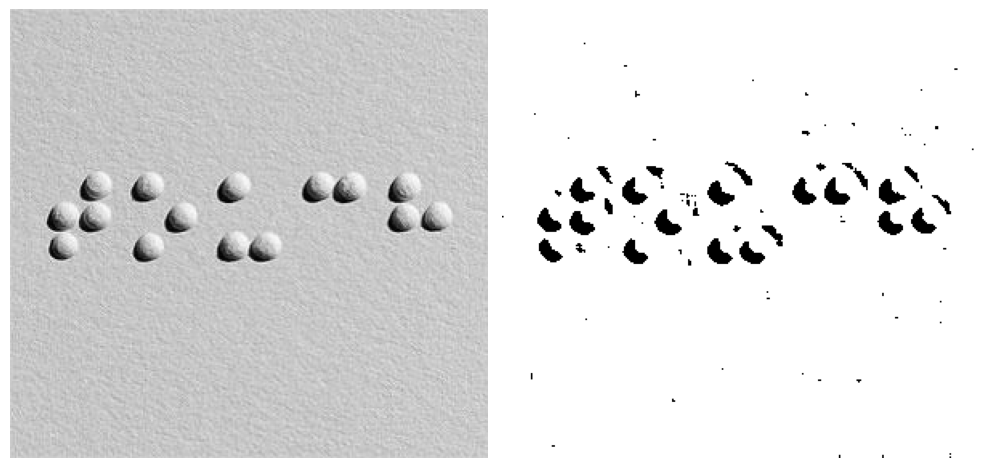

In [5]:
import cv2
import numpy as np

# Load the image
# image = cv2.imread("../images/tests/test_1.png", cv2.IMREAD_GRAYSCALE)

# gray = cv2.bitwise_not(image)
gray = (image)

blurred = cv2.GaussianBlur(gray, (7, 7), 5)
binary_raw = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY, 5, 1)
binary = cv2.medianBlur(binary_raw, 7)

# Show the result
plt_show2(gray, binary)


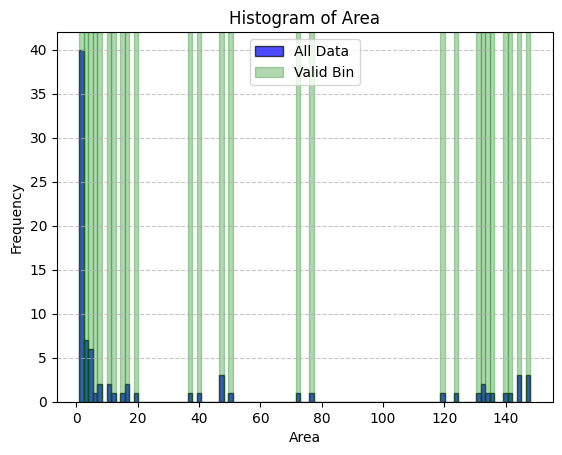

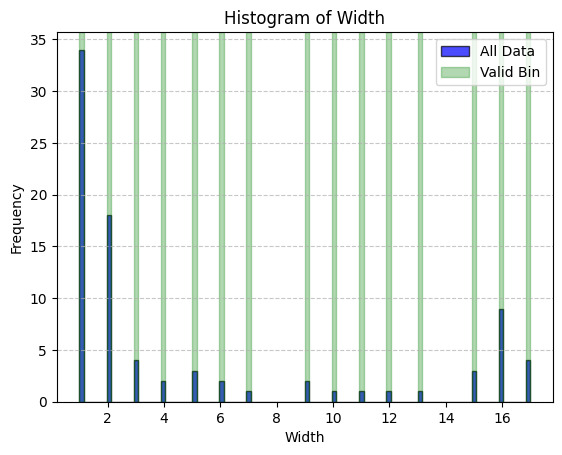

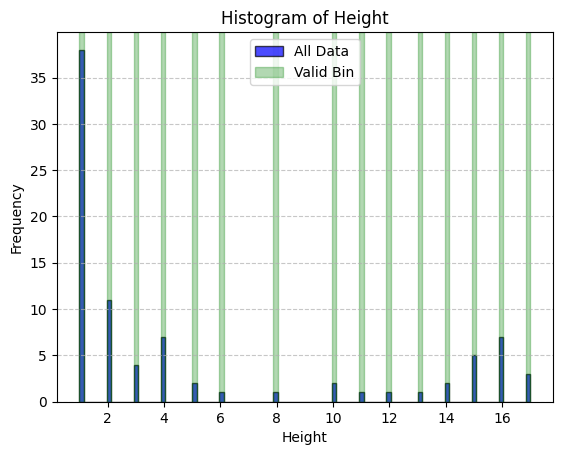

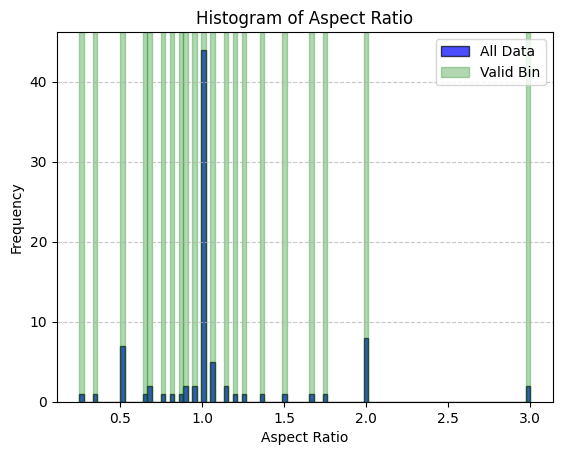

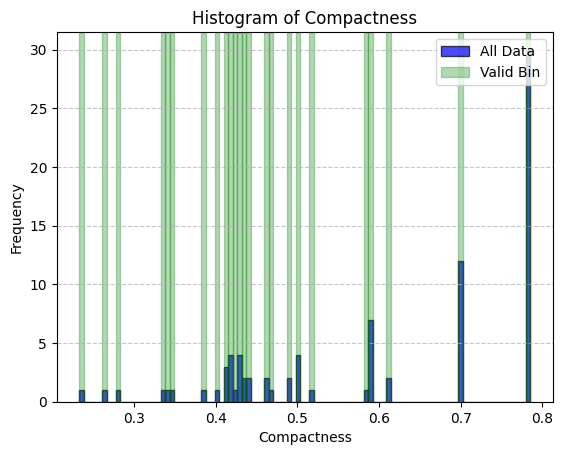

In [6]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binary))

# Initialize lists for properties
areas = []
widths = []
heights = []
aspect_ratios = []
compactness = []
component_indices = []

# Loop through each component (skip background, label 0)
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    # Compute additional properties
    aspect_ratio = w / h if h != 0 else 0
    perimeter = 2 * (w + h)
    compactness_val = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

    # Store properties
    component_indices.append(i)
    areas.append(area)
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(aspect_ratio)
    compactness.append(compactness_val)

# Create histograms for each property
properties = {
    "Area": areas,
    "Width": widths,
    "Height": heights,
    "Aspect Ratio": aspect_ratios,
    "Compactness": compactness,
}

filtered_components = {prop_name: [] for prop_name in properties.keys()}

for prop_name, values in properties.items():
    # Compute histogram
    hist, bin_edges = np.histogram(values, bins=100)
    total_elements = len(values)

    # Determine bins with less than 2% of elements
    threshold = 0.002 * total_elements
    valid_bins = [i for i, count in enumerate(hist) if count >= threshold]

    # Filter components based on the valid bins
    valid_range = []
    for i in valid_bins:
        valid_range.append((bin_edges[i], bin_edges[i + 1]))

    for i, val in enumerate(values):
        if any(low <= val < high for low, high in valid_range):
            filtered_components[prop_name].append(component_indices[i])

    # Plot the histogram with valid and invalid bins highlighted
    plt.figure()
    plt.hist(values, bins=100, color='blue', alpha=0.7, edgecolor='black', label="All Data")
    for i in valid_bins:
        plt.axvspan(bin_edges[i], bin_edges[i + 1], color='green', alpha=0.3, label="Valid Bin" if i == valid_bins[0] else "")
    plt.title(f"Histogram of {prop_name}")
    plt.xlabel(prop_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


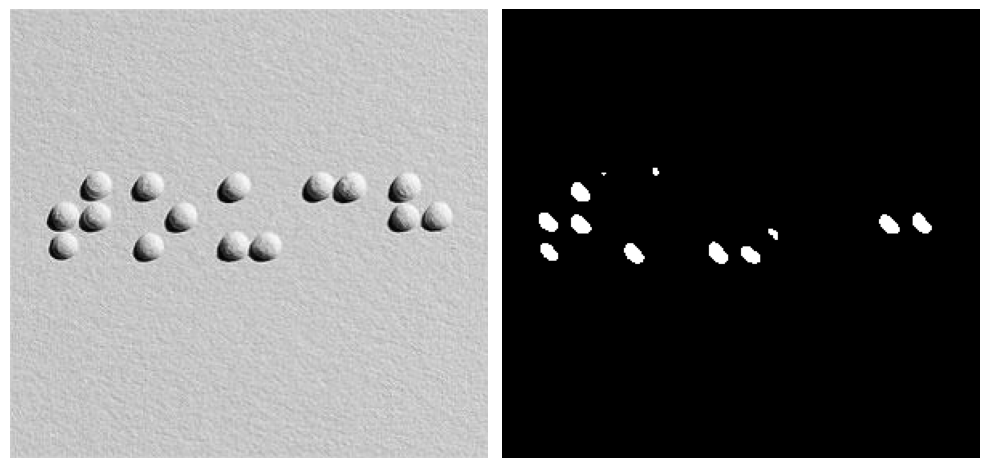

23


In [7]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binary))

# Initialize lists for properties
areas = []
widths = []
heights = []
aspect_ratios = []
compactness = []
component_indices = []

# Loop through each component (skip background, label 0)
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]

    # Compute additional properties
    aspect_ratio = w / h if h != 0 else 0
    perimeter = 2 * (w + h)
    compactness_val = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

    # Store properties
    component_indices.append(i)
    areas.append(area)
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(aspect_ratio)
    compactness.append(compactness_val)

# Create histograms and determine valid bins for each property
properties = {
    "Area": areas,
    "Width": widths,
    "Height": heights,
    "Aspect Ratio": aspect_ratios,
    "Compactness": compactness,
}

# Store the indices of valid components for each property
valid_components = {prop_name: [] for prop_name in properties.keys()}

for prop_name, values in properties.items():
    # Compute histogram
    hist, bin_edges = np.histogram(values, bins=20)
    total_elements = len(values)
    
    # Determine bins with less than 1% of elements
    threshold = 0.005 * total_elements
    valid_bins = [i for i, count in enumerate(hist) if count >= threshold]

    # Get valid ranges for each property
    valid_range = []
    for i in valid_bins:
        valid_range.append((bin_edges[i], bin_edges[i + 1]))

    # Identify the valid components for this property
    for i, val in enumerate(values):
        if any(low <= val < high for low, high in valid_range):
            if np.median(area) >= 100:
                if 0.33 <= aspect_ratios[i] <= 3 and  0.4 < compactness[i] < 0.75:
                    valid_components[prop_name].append(component_indices[i])
            else:
                if 0.45 <= aspect_ratios[i] <= 2.5 and  0.25 < compactness[i] and areas[i] >= 10:
                    valid_components[prop_name].append(component_indices[i])

final_valid_indices = []
for i in range(1, num_labels):
    if all(i in valid_components[prop_name] for prop_name in valid_components):
        
        final_valid_indices.append(i)

# Create the filtered image
filtered_image = np.zeros_like(binary)

for idx in final_valid_indices:
    filtered_image[labels == idx] = 255

filtered_image = cv2.medianBlur(filtered_image, 9)
plt_show2(image, filtered_image)
print(len(final_valid_indices))


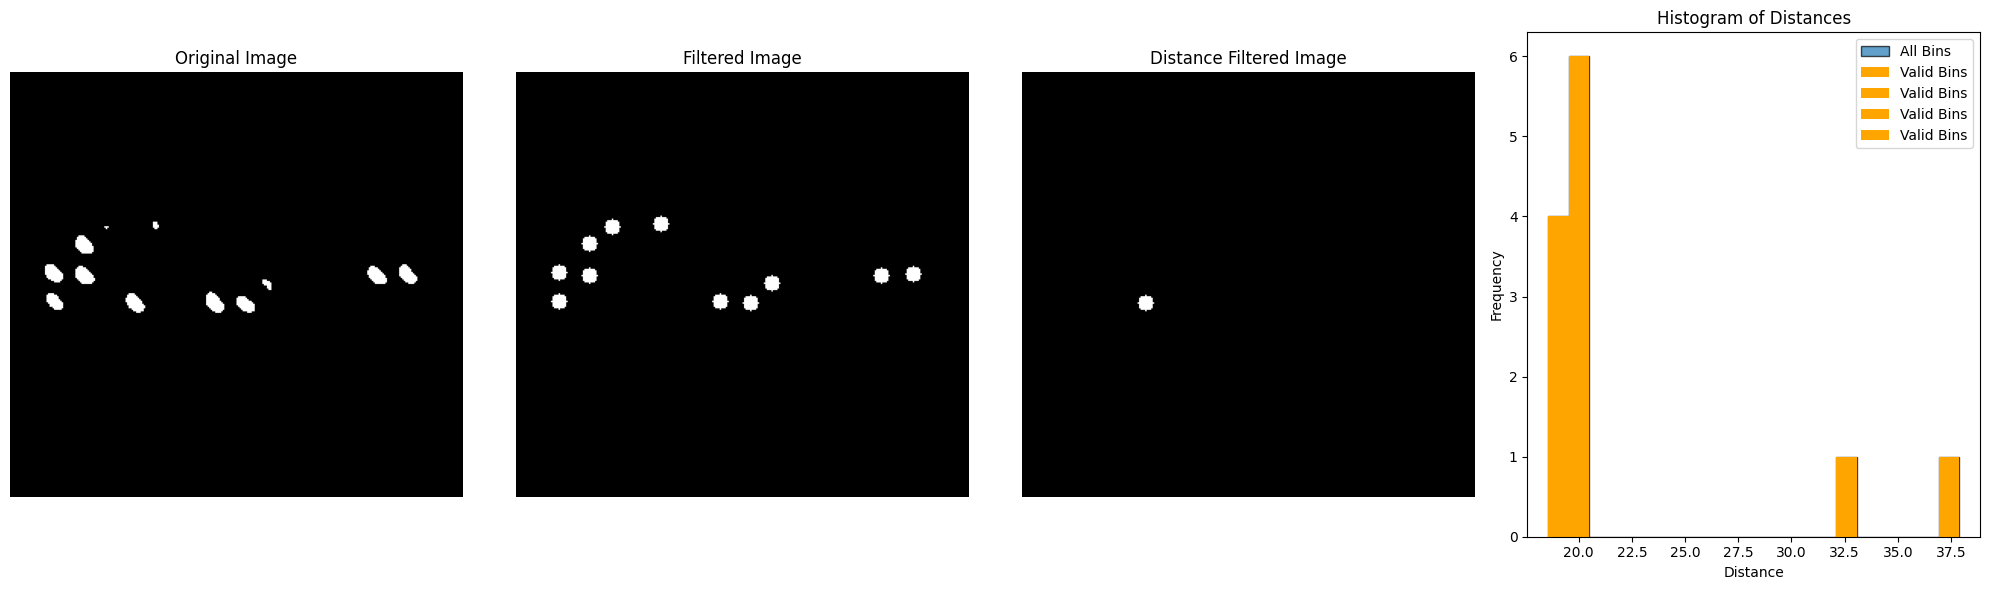

In [ ]:
# Function to compute nearest-neighbor distances
def nearest_neighbor_distances(centroids):
    n = len(centroids)
    distances = []
    for i in range(n):
        # Compute distances to all other centroids
        dists = np.linalg.norm(centroids - centroids[i], axis=1)
        # Find the nearest distance (excluding itself)
        nearest = np.min(dists[dists > 0])
        distances.append(nearest)
    return np.array(distances)

def filter_points(binary_image, centroids, distances, bins=20, threshold=0.01):
    # Compute histogram
    hist, bin_edges = np.histogram(distances, bins=bins)
    total = np.sum(hist)

    # Identify valid ranges based on histogram bins
    valid_ranges = []
    for i in range(len(bin_edges) - 1):
        if hist[i] >= threshold * total:
            valid_ranges.append((bin_edges[i], bin_edges[i+1]))

    # Find centroids to keep
    keep_centroids = []
    remove_centroids = []
    for centroid, dist in zip(centroids, distances):
        if any(lower <= dist < upper for lower, upper in valid_ranges):
            keep_centroids.append(centroid)
        else:
            remove_centroids.append(centroid)

    # Create filtered binary images
    filtered_image = np.zeros_like(binary_image)
    distance_filtered = np.zeros_like(binary_image)

    for c in keep_centroids:
        cv2.circle(filtered_image, (int(c[0]), int(c[1])), 5, 255, -1)
    for c in remove_centroids:
        cv2.circle(distance_filtered, (int(c[0]), int(c[1])), 5, 255, -1)

    return filtered_image, distance_filtered, hist, bin_edges, valid_ranges
# Example binary image
binary_image = filtered_image

# Find centroids of connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

# Calculate distances
distances = nearest_neighbor_distances(centroids[1:])  # Exclude background centroid (index 0)

# Get filtered images
filtered_image2, distance_filtered, hist, bin_edges, valid_ranges = filter_points(binary_image, centroids[1:], distances, bins=20, threshold=0.01)

# Plot the results
plt.figure(figsize=(20, 6))

# Original binary image
plt.subplot(1, 4, 1)
plt.imshow(binary_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Filtered image
plt.subplot(1, 4, 2)
plt.imshow(filtered_image2, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Distance filtered image
plt.subplot(1, 4, 3)
plt.imshow(distance_filtered, cmap='gray')
plt.title("Distance Filtered Image")
plt.axis('off')

# Histogram with highlighted valid bins
plt.subplot(1, 4, 4)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), edgecolor='black', alpha=0.7, label='All Bins')

# Highlight valid bins
for lower, upper in valid_ranges:
    mask = (bin_centers >= lower) & (bin_centers < upper)
    plt.bar(bin_centers[mask], hist[mask], width=np.diff(bin_edges)[0], color='orange', label='Valid Bins')

plt.title("Histogram of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


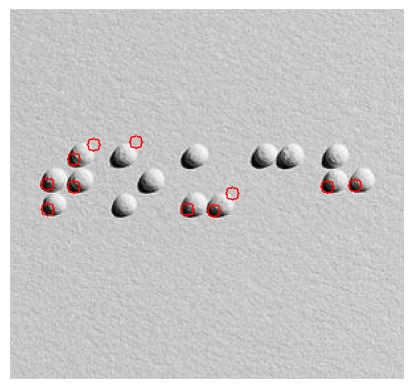

In [73]:
contours, _ = cv2.findContours(filtered_image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create a plot
fig, ax = plt.subplots()

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax.imshow(image_rgb)
ax.axis('off')  # Hide axis

# Define a threshold for circularity
circularity_threshold = 0.1  # Adjust as needed

# Iterate through contours
for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, closed=True)
    
    if perimeter > 0:  # Avoid division by zero
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        
        # Filter for contours with circularity close to 1 (round)
        if circularity >= circularity_threshold:
            contour = contour.squeeze()
            ax.plot(contour[:, 0], contour[:, 1], color='red', linewidth=1)

plt.show()

In [74]:
print(centroids)
np.save('centroids.npy', centroids)

[[148.89351459 139.51192064]
 [ 95.3125     100.9375    ]
 [ 63.         102.25      ]
 [ 48.26168224 113.95327103]
 [ 28.16190476 132.58095238]
 [261.         133.37254902]
 [ 48.39090909 134.01818182]
 [240.77142857 134.        ]
 [168.81481481 139.62962963]
 [134.0877193  151.93859649]
 [ 28.8255814  151.12790698]
 [ 81.68518519 152.10185185]
 [154.40425532 152.96808511]]


In [75]:
# Calculate the mean nearest-neighbor distance
def mean_nearest_neighbor_distance(points):
    n = points.shape[0]
    distances = np.zeros(n)

    for i in range(n):
        # Compute distances from point i to all other points
        dist_to_all = np.linalg.norm(points - points[i], axis=1)
        # Find the nearest neighbor distance (ignoring itself)
        distances[i] = np.min(dist_to_all[dist_to_all > 0])
    
    return np.mean(distances), np.median(distances)

mean_distance, median_distance = mean_nearest_neighbor_distance(centroids)
print(f"Mean/Median nearest-neighbor distance: {mean_distance} {median_distance}")

Mean/Median nearest-neighbor distance: 21.044165826225512 19.329610622927177


In [76]:
# # Hough Circle Transform
# img_circles = image.copy()
# filtered_image_circle = cv2.medianBlur(filtered_image, 11)
# mean = np.mean(area)
# base_dia = np.sqrt(mean/np.pi)*2
# circles = cv2.HoughCircles(filtered_image_circle, cv2.HOUGH_GRADIENT_ALT, dp=.01, minDist=base_dia//2,
#                            param1=60, param2=.1, minRadius=int(base_dia*0.5), maxRadius=int(base_dia*1.2*3))

# # Draw the detected circle
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for i in circles[0, :]:
#         # Draw the circle
#         cv2.circle(img_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)
        
# plt_show2(filtered_image_circle, img_circles)

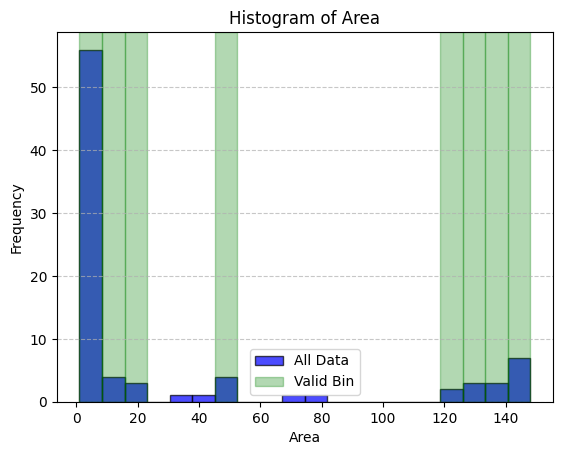

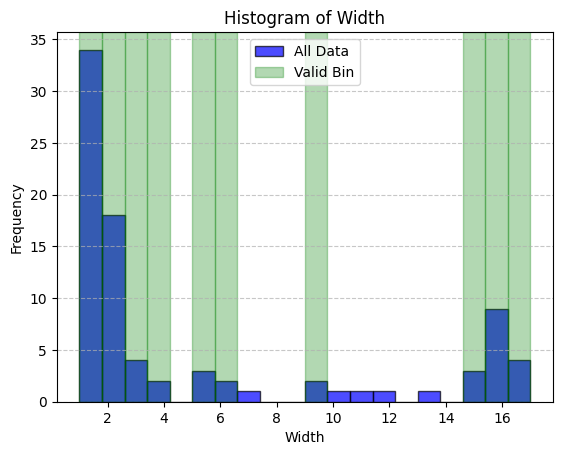

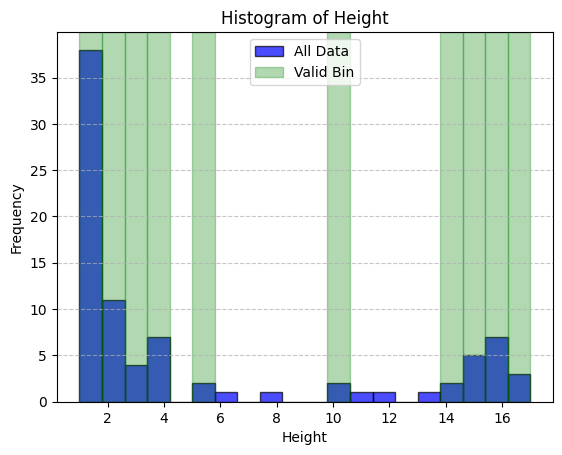

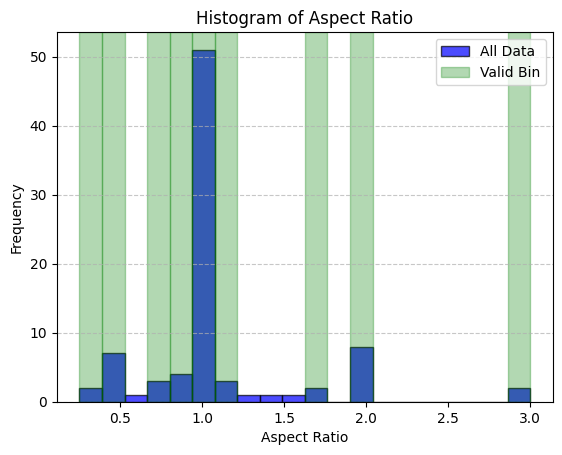

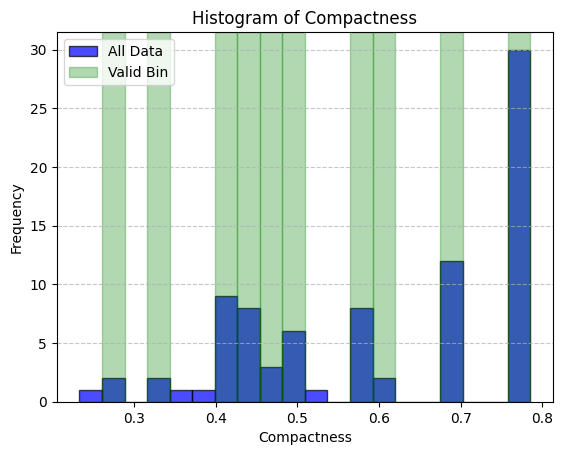

In [77]:

filtered_components = {prop_name: [] for prop_name in properties.keys()}

for prop_name, values in properties.items():
    # Compute histogram
    hist, bin_edges = np.histogram(values, bins=20)
    total_elements = len(values)

    # Determine bins with less than 2% of elements
    threshold = 0.02 * total_elements
    valid_bins = [i for i, count in enumerate(hist) if count >= threshold]

    # Filter components based on the valid bins
    valid_range = []
    for i in valid_bins:
        valid_range.append((bin_edges[i], bin_edges[i + 1]))

    for i, val in enumerate(values):
        if any(low <= val < high for low, high in valid_range):
            filtered_components[prop_name].append(component_indices[i])

    # Plot the histogram with valid and invalid bins highlighted
    plt.figure()
    plt.hist(values, bins=20, color='blue', alpha=0.7, edgecolor='black', label="All Data")
    for i in valid_bins:
        plt.axvspan(bin_edges[i], bin_edges[i + 1], color='green', alpha=0.3, label="Valid Bin" if i == valid_bins[0] else "")
    plt.title(f"Histogram of {prop_name}")
    plt.xlabel(prop_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [78]:
# img = image.copy()
# assert img is not None, "file could not be read, check with os.path.exists()"
# img = cv2.GaussianBlur(image, (7, 7), 5)
 
# ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
# th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,17,5)
# th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,9,1)
 
# titles = ['Original Image', 'Global Thresholding (v = 127)',
#             'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
# images = [img, th1, th2, th3]

# plt.figure(figsize=(10, 5), dpi=350)
# for i in range(4):
#     plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
# plt.show()

In [79]:
# # Preprocesamiento
# img = image.copy()
# assert img is not None, "file could not be read, check with os.path.exists()"
# ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
# ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
# ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
# ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
 
# titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
# images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
 
# plt.figure(figsize=(10, 5), dpi=350)
# for i in range(6):
#     plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
 
# plt.show()

In [80]:

# # Load the image
# img_gray = binary_raw
# # Apply different filters
# filters = {
#     "Original": img_gray,
#     "Gaussian Blur (11x11)": cv2.GaussianBlur(img_gray, (11, 11), 0),
#     "Median Blur (11x11)": cv2.medianBlur(img_gray, 11),
#     "Bilateral Filter (9,75,75)": cv2.bilateralFilter(img_gray, 13, 75, 75),
#     "Box Filter (5x5)": cv2.blur(img_gray, (15, 15)),
#     "Sobel X": cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=11),
#     "Sobel Y": cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=5),
#     "Laplacian": cv2.Laplacian(img_gray, cv2.CV_64F)
# }

# # Create subplots
# num_filters = len(filters)
# plt.figure(figsize=(15, 10))

# for i, (title, filtered_image) in enumerate(filters.items(), 1):
#     plt.subplot(2, (num_filters + 1) // 2, i)
    
#     # Handle gradient images separately for visualization
#     if title in ["Sobel X", "Sobel Y", "Laplacian"]:
#         filtered_image = cv2.convertScaleAbs(filtered_image)
    
#     plt.imshow(filtered_image, cmap='gray')
#     plt.title(title)
#     plt.axis('off')

# # Display all the filters
# plt.tight_layout()
# plt.show()
